In [155]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from network import Model

from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import json

In [156]:
# feature_names_master = ['DNMS fix1', 'DNMC fix1', 'Dly Anti fix1', 'DMC fix1',
#        'Ctx Dly DM 2 fix1', 'Anti fix1', 'Dly DM 1 fix1', 'Dly DM 2 fix1',
#        'MultSen Dly DM fix1', 'Go fix1', 'Dly Go fix1',
#        'Ctx Dly DM 1 fix1', 'DMS fix1', 'RT Go fix1', 'RT Anti fix1',
#        'DMS delay1', 'DMS go1', 'Ctx Dly DM 2 go1', 'Ctx Dly DM 1 go1',
#        'MultSen Dly DM go1', 'Go go1', 'Dly Go go1', 'Dly DM 1 go1',
#        'Dly DM 2 go1', 'Anti go1', 'Anti stim1', 'Ctx Dly DM 2 delay1',
#        'Ctx Dly DM 2 delay2', 'Ctx Dly DM 1 delay2',
#        'Ctx Dly DM 1 delay1', 'MultSen Dly DM delay1',
#        'MultSen Dly DM delay2', 'Dly DM 1 delay1', 'Dly DM 2 delay1',
#        'Dly Go delay1', 'Dly DM 1 delay2', 'Dly DM 2 delay2',
#        'DMC delay1', 'DNMC delay1', 'Dly Anti delay1', 'Dly Anti go1',
#        'DMC stim1', 'Dly Anti stim1', 'Dly Go stim1', 'DMS stim1',
#        'MultSen Dly DM stim1', 'MultSen Dly DM stim2', 'Dly DM 2 stim1',
#        'Ctx Dly DM 2 stim1', 'Dly DM 2 stim2', 'Ctx Dly DM 2 stim2',
#        'Ctx Dly DM 1 stim1', 'Ctx Dly DM 1 stim2', 'Dly DM 1 stim2',
#        'Go stim1', 'Dly DM 1 stim1', 'RT Anti go1', 'DNMS go1',
#        'RT Go go1', 'DMC go1', 'DNMC go1', 'DNMS delay1', 'DNMS stim1',
#        'DNMC stim1']


feature_names_master = ['DNMS go1', 'DMS go1', 'RT Go go1', 'DMC go1', 'DNMC go1',
       'RT Anti fix1', 'RT Go fix1', 'DNMC fix1', 'Dly DM 1 fix1',
       'Ctx Dly DM 1 fix1', 'DNMS fix1', 'DMS fix1', 'Anti fix1',
       'Dly Anti fix1', 'DMC fix1', 'Ctx Dly DM 2 fix1', 'Go fix1',
       'MultSen Dly DM fix1', 'Dly Go fix1', 'Dly DM 2 fix1',
       'Dly Go go1', 'Dly Anti go1', 'Ctx Dly DM 2 go1',
       'Ctx Dly DM 1 go1', 'MultSen Dly DM go1', 'Dly DM 1 go1',
       'Dly DM 2 go1', 'RT Anti go1', 'Go go1', 'Anti go1', 'Anti stim1',
       'Dly Anti stim1', 'Dly DM 1 stim1', 'Go stim1', 'Dly Go stim1',
       'Dly DM 2 stim1', 'Ctx Dly DM 1 stim1', 'Ctx Dly DM 2 stim1',
       'MultSen Dly DM stim1', 'Dly DM 1 delay2', 'Dly DM 2 delay2',
       'Dly Anti delay1', 'Ctx Dly DM 2 delay2', 'Ctx Dly DM 1 delay2',
       'MultSen Dly DM delay2', 'Dly Go delay1', 'Ctx Dly DM 1 delay1',
       'MultSen Dly DM delay1', 'Dly DM 1 delay1', 'Dly DM 2 delay1',
       'Ctx Dly DM 2 delay1', 'DMS stim1', 'DNMS stim1', 'DMC stim1',
       'DNMC stim1', 'Dly DM 1 stim2', 'Dly DM 2 stim2',
       'Ctx Dly DM 1 stim2', 'Ctx Dly DM 2 stim2', 'MultSen Dly DM stim2',
       'DNMS delay1', 'DMS delay1', 'DMC delay1', 'DNMC delay1']



In [157]:
from numpy import eye, asarray, dot, sum, diag
from numpy.linalg import svd
def varimax(Phi, gamma = 1.0, q = 100, tol = 1e-6):
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in xrange(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        print(i)
        if d_old!=0 and d/d_old < 1 + tol: break
    return R, dot(Phi, R)

In [158]:
def remove_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

def remove_ticks(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    
def plot_epoch_labels(ax, which_axes = 'y', ms = 3):
    
    e_set = ['stim1','stim2','delay1','delay2','go1']
    e_color = plt.get_cmap('terrain')
    
    yl = np.max(ax.get_ylim())+2
    xl = np.max(ax.get_xlim())+2
    
    for ei in range(len(e_set)):
        e_name = e_set[ei]
        c = e_color(ei/len(e_set))
        
        if 'y' in which_axes:
            
            ax.plot(np.where(epoch_binary[e_name])[0],
                     yl*np.ones(np.sum(epoch_binary[e_name])),'s',
                     color = c,markersize = ms,label = e_name)
            
        if 'x' in which_axes:
            
            ax.plot(xl*np.ones(np.sum(epoch_binary[e_name])),
                     np.where(epoch_binary[e_name])[0],'s',
                     color = c,markersize = ms,label = e_name)

In [159]:
from scipy.cluster import hierarchy
hierarchy.set_link_color_palette(['k','c', 'm', 'y'])

In [160]:
##################################################################
#Find right model dir
##################################################################
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
method = 'ward'
max_d = 3.5
sparsity_threshold = .15
ex_1 = 1
ex_2 = 6
ex_3 = 8
al = .3
seed_set = [str(0),str(1),str(2)]#[str(0),str(1)]

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_trains_str = '_'.join(rule_trains)

n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder_all = 'data/rnn/multitask/stepnet/'

# identify master network to compare other networks to. can be chosen randomly
rnn_type_master = 'LeakyRNN'
activation_master = 'retanh'
w_init_master = 'diag'
label_master = ' '.join([rnn_type_master,activation_master,w_init_master])
seed_master = str(0)
m_master = os.path.join(p,data_folder_all,'lr',rnn_type_master,activation_master,w_init_master,
                        n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed_master)
lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+'distance'+'_max_d'+str(max_d)
save_dir = os.path.join(m_master,lesion_folder)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
feature_names_master = cluster_var['tick_names']

# set of networks to compare
rnn_type_set = ['GRU','LeakyRNN']
activation_set = ['softplus','retanh','tanh']
w_init_set = ['diag','randgauss']
data_folder_set = ['lr','untrained']
color_set = {}
color_set['lr'] = 'k'
color_set['untrained'] = 'm'
color_set['no_noise'] = 'dodgerblue'
  
tril_corr_mat_ave = {}

for rnn_type_i in range(len(rnn_type_set)):
    
    rnn_type = rnn_type_set[rnn_type_i]
    tril_corr_mat_ave[rnn_type] = {}
    
    for activation_i in range(len(activation_set)):
        
        activation = activation_set[activation_i]
        tril_corr_mat_ave[rnn_type][activation]= {}
        
        for w_init_i in range(len(w_init_set)):
            
            w_init = w_init_set[w_init_i]
            tril_corr_mat_ave[rnn_type][activation][w_init] = {}

            for data_folder in data_folder_set:
                
                tril_corr_mat_ave[rnn_type][activation][w_init][data_folder] = {}

                for seed in seed_set:
                    
                    if data_folder=='no_noise':
                        l2w = -0
                        l2h = -0
                    else:
                        l2w = -6
                        l2h = -6
                        
                    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str

                    m = os.path.join(p,data_folder_all,data_folder,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',
                                     net_name,seed)

                    #load atlas data
                    save_dir = os.path.join(m,lesion_folder)
                    cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
                    D = cluster_var['D'].T
                    feature_names_original = [cluster_var['tick_names'][s] for s in 
                                              range(len(cluster_var['tick_names']))]

                    feat_order = [feature_names_original.index(s) for i,s in enumerate(feature_names_master)]
                    X = D[:,feat_order]
                    corr_mat = np.corrcoef(X.T)

                    if seed==seed_set[0]:
                        corr_mat_stack = corr_mat[:,np.newaxis]
                    else:
                        corr_mat_stack = np.concatenate((corr_mat_stack,corr_mat[:,np.newaxis]),axis=1)
            
                corr_mat_ave = np.mean(corr_mat_stack,axis = 1)
                tril_corr_mat_ave[rnn_type][activation][w_init][data_folder] = corr_mat_ave[np.tril_indices(len(corr_mat_ave),-1)]

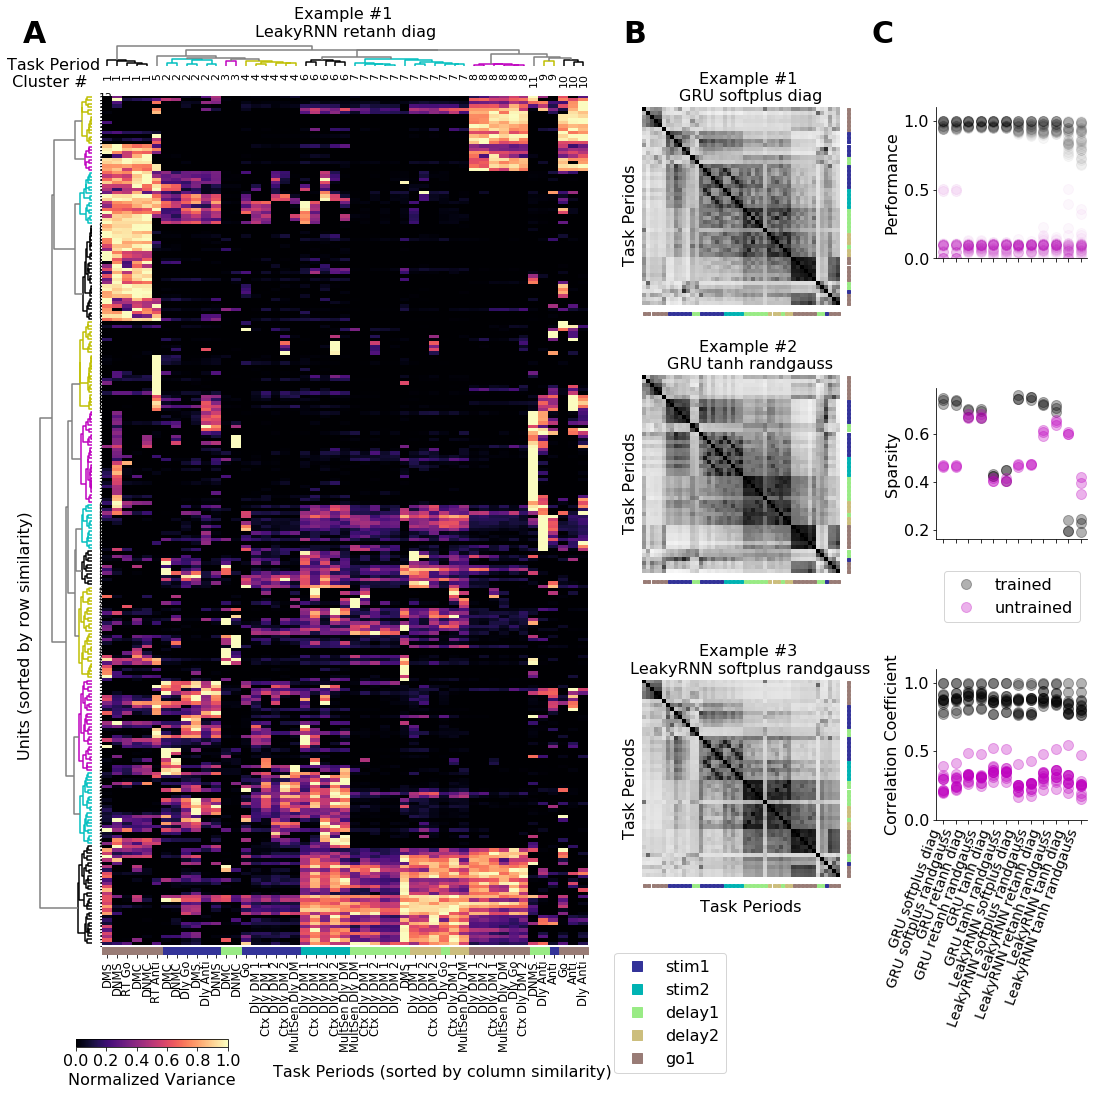

In [162]:
### load master network and make average correlation matrix across seeds
for seed in seed_set:
    m_master = os.path.join(p,data_folder_all,'lr',rnn_type_master,activation_master,w_init_master,
                        n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed_master)
    lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+'distance'+'_max_d'+str(max_d)
    save_dir = os.path.join(m_master,lesion_folder)
    cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
    
    if seed==seed_set[0]:
        feature_names_master = cluster_var['tick_names']
        len_te = len(feature_names_master)
        feature_names_labels = [feat_name.rsplit(' ', 1)[0] for feat_name in feature_names_master]
        epoch_binary = {}
        for e_name in ['delay1','delay2','go1','stim1','stim2']:
            epoch_binary[e_name] = [feat_name.rsplit(' ', 1)[-1]==e_name for 
                                    feat_name in feature_names_master]
    
    D = cluster_var['D'].T
    feature_names_original = [cluster_var['tick_names'][s] for s in range(len(cluster_var['tick_names']))]

    feat_order = [feature_names_original.index(s) for i,s in enumerate(feature_names_master)]
    X = D[:,feat_order]

#visualize atlas for master network
fig = plt.figure(figsize=(15,15))
plt.rcParams.update({'font.size': 16})
legend_done = 0
atlas_width = .5
atlas_height = .88
thresh = 6

axdendro_top = fig.add_axes([.06,atlas_height+.078,atlas_width-.05,.02])
Y = sch.linkage(X.T, method=method)
clusters_top = fcluster(Y, thresh, criterion='distance')
Z_top = sch.dendrogram(Y, orientation='top',#labels = clusters, #CA.ind_active #clusters
                   leaf_font_size = 11,color_threshold=thresh,
                          above_threshold_color='gray', labels = clusters_top)
plt.text(-96,-18,'Task Period \n Cluster #')
plt.text(-80,20,'A',fontsize = 30, fontweight='bold')

plt.text(525,20,'B',fontsize = 30, fontweight='bold')
plt.text(775,20,'C',fontsize = 30, fontweight='bold')

remove_spines(axdendro_top)
axdendro_top.set_yticks([])

axdendro = fig.add_axes([0,.145,0.05,.786])
Y = sch.linkage(X, method=method)
clusters = fcluster(Y, 5, criterion='distance')
Z = sch.dendrogram(Y, orientation='left',#labels = clusters, #CA.ind_active #clusters
                   leaf_font_size = 11,color_threshold=5,
                          above_threshold_color='gray', labels = clusters)
remove_spines(axdendro)
# remove_ticks(axdendro)
axdendro.set_xticks([])


axmatrix = fig.add_axes([.06,0.05,atlas_width-.05,atlas_height])#fig.add_subplot(1,2,1)
index_top = Z['leaves']
X = X[index_top,:]
plt.imshow(X[-1:0:-1,:],cmap= 'magma', aspect='auto')

axmatrix.set_xticks(range(len_te))
axmatrix.set_xticklabels(feature_names_labels,fontsize = 11.5, rotation =90,ha = 'center')
plot_epoch_labels(axmatrix,which_axes = 'y',ms = 10)
plt.legend(bbox_to_anchor=(1.3, 0.01))    

plt.text(-9,128,'Units (sorted by row similarity)',rotation = 90)
axmatrix.set_xlabel('Task Periods (sorted by column similarity)')
axmatrix.xaxis.set_label_coords(.7, -.13)
plt.title('Example #1 \n'+label_master, fontsize = 16, pad=60)
cbar = plt.colorbar(orientation="horizontal",fraction=0.008, pad=.09,anchor=(-.08,0.0))
cbar.set_label('Normalized Variance')
remove_spines(axmatrix)
axmatrix.set_yticks([])
plt.ylim((257,0))

# make subpanels.
sp_width = .14
sp_wide = .2
offset = .06
perf_ax = fig.add_axes([2.2*offset+atlas_width+sp_wide,3*sp_wide+3*offset,sp_width,sp_width])
sparsity_ax = fig.add_axes([2.2*offset+atlas_width+sp_wide,2*sp_wide+2*offset,sp_width,sp_width])
corr_ax = fig.add_axes([2.2*offset+atlas_width+sp_wide,sp_wide+offset,sp_width,sp_width])
corrmatex1 = fig.add_axes([offset+atlas_width,3*sp_wide+2*offset,sp_wide,sp_wide])
corrmatex2 = fig.add_axes([offset+atlas_width,2*sp_wide+1.2*offset,sp_wide,sp_wide])
corrmatex3 = fig.add_axes([offset+atlas_width,sp_wide-offset,sp_wide,sp_wide+.1])

# x-axis for plotting each networks correlation coeff, sparsity, performance
x_ind_counter = 0
ax1_xticks = []

for rnn_type_i in range(len(rnn_type_set)):
    for activation_i in range(len(activation_set)):
        for w_init_i in range(len(w_init_set)):
            for data_folder in data_folder_set:
            
                c = color_set[data_folder]
                rnn_type = rnn_type_set[rnn_type_i]
                activation = activation_set[activation_i]
                w_init = w_init_set[w_init_i]

                # x-axis and labelling bs
                if data_folder==data_folder_set[0]:
                    x_ind_counter+=1
                    label = ' '.join([rnn_type,activation,w_init])
                    if len(ax1_xticks)==0:
                        ax1_xticks = [label,]
                    else:
                        ax1_xticks.append(label)

                for seed in seed_set:
                    
                    if data_folder=='no_noise':
                        l2w = -0
                        l2h = -0
                    else:
                        l2w = -6
                        l2h = -6
                        
                    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str

                    m = os.path.join(p,data_folder_all,data_folder,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',
                                     net_name,seed)

                    #load performance data
                    fname = os.path.join(m, 'log.json')
                    with open(fname, 'r') as f:
                        log_all = json.load(f)
                        for r in range(len(rule_trains)):
                            x = log_all['perf_' + rule_trains[r]]
                            perf_ax.plot(x_ind_counter,x[-1],'o',alpha = al/10,c = c, markersize = 10)

                    #load atlas data
                    save_dir = os.path.join(m,lesion_folder)
                    cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
                    D = cluster_var['D'].T
                    feature_names_original = [cluster_var['tick_names'][s] for s in range(len(cluster_var['tick_names']))]

                    feat_order = [feature_names_original.index(s) for i,s in enumerate(feature_names_master)]
                    X = D[:,feat_order]

                    corr_mat = np.corrcoef(X.T)

                    if seed==seed_set[0]:
                        corr_mat_stack = corr_mat[:,np.newaxis]
                    else:
                        corr_mat_stack = np.concatenate((corr_mat_stack,corr_mat[:,np.newaxis]),axis=1)

                    #calculate sparsity based on density of non-zero (below theshold) values
                    sparsity_metric_num = len_te*(np.float(n_rnn)-len(D))+np.sum(D.flatten()<sparsity_threshold)
                    sparsity_metric_denom = len_te*np.float(n_rnn)
                    sparsity_metric = sparsity_metric_num/sparsity_metric_denom
                    sparsity_ax.plot(x_ind_counter,sparsity_metric,'o',alpha = al,c = c, markersize = 10)

                if data_folder=='lr':
                    corr_mat_ave = np.mean(corr_mat_stack,axis = 1)
                    tril_corr_mat_master = tril_corr_mat_ave[rnn_type][activation][w_init][data_folder]

                    for rnn_type_sub in range(len(rnn_type_set)):
                        for activation_sub in range(len(activation_set)):
                            for w_init_sub in range(len(w_init_set)):
                                for data_folder_sub in data_folder_set:

                                    rnn_type = rnn_type_set[rnn_type_sub]
                                    activation = activation_set[activation_sub]
                                    w_init = w_init_set[w_init_sub]

                                    tril_corr_mat_sub = tril_corr_mat_ave[rnn_type][activation][w_init][data_folder_sub]

                                    corr, pval = pearsonr(tril_corr_mat_master,tril_corr_mat_sub)

                                    corr_ax.plot(x_ind_counter,corr,'o',c=color_set[data_folder_sub],
                                                 alpha = al, markersize = 10)
                                if legend_done==0:
                                    corr_ax.legend(['trained','untrained','no noise/reg'],loc='upper center', 
                                                   bbox_to_anchor=(0.5, 1.7))
                                    legend_done = 1

                    # plot corr_mat examples
                    if x_ind_counter==ex_1:
                        plt.sca(corrmatex1)
                        ex_label = 'Example #1 \n'
                    elif x_ind_counter==ex_2:
                        plt.sca(corrmatex2)
                        ex_label = 'Example #2 \n'
                    elif x_ind_counter==ex_3:
                        plt.sca(corrmatex3)
                        ex_label = 'Example #3 \n'
                        plt.xlabel('Task Periods')

                    if x_ind_counter==ex_1 or x_ind_counter==ex_2 or x_ind_counter==ex_3:
                        plt.imshow(corr_mat_ave,cmap= 'Greys',clim = (-.5,1))
                        plt.title(ex_label+label, fontsize = 16)
                        if x_ind_counter==ex_3 and seed==seed_set[0]:
                            cbar = plt.colorbar(orientation="horizontal", ticks=[-1, 0, 1],anchor=(0,1.5))
                            cbar.set_label('Correlation Coefficient')

                    plt.ylabel('Task Periods')
                    
                corr_mat_stack = []

# visualization beautification bs
corr_ax.set_xticks(range(1,len(ax1_xticks)+1))
corr_ax.set_xticklabels(ax1_xticks,rotation = 70,ha = 'right',fontsize = 14)
corr_ax.set_ylabel('Correlation Coefficient')
corr_ax.set_ylim((0,1.1))
corr_ax.spines['top'].set_visible(False)
corr_ax.spines['right'].set_visible(False)

sparsity_ax.set_xticks(range(1,len(ax1_xticks)+1))
sparsity_ax.set_xticklabels([])
sparsity_ax.set_ylabel('Sparsity')
sparsity_ax.spines['top'].set_visible(False)
sparsity_ax.spines['right'].set_visible(False)

perf_ax.set_xticks(range(1,len(ax1_xticks)+1))
perf_ax.set_xticklabels([])
perf_ax.set_ylabel('Performance')
perf_ax.spines['top'].set_visible(False)
perf_ax.spines['right'].set_visible(False)
perf_ax.set_ylim((0,1.1))

plot_epoch_labels(corrmatex1,which_axes = 'xy')
remove_ticks(corrmatex1)
remove_spines(corrmatex1)

plot_epoch_labels(corrmatex2,which_axes = 'xy')
remove_ticks(corrmatex2)
remove_spines(corrmatex2)

plot_epoch_labels(corrmatex3,which_axes = 'xy')
remove_ticks(corrmatex3)
remove_spines(corrmatex3)

plt.show()

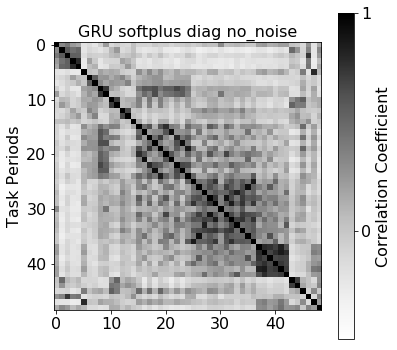

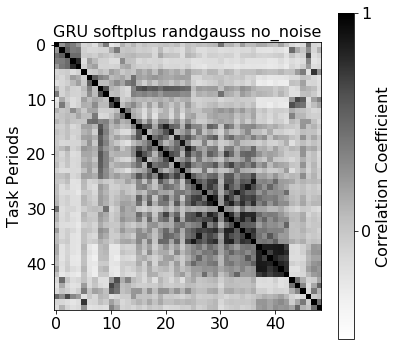

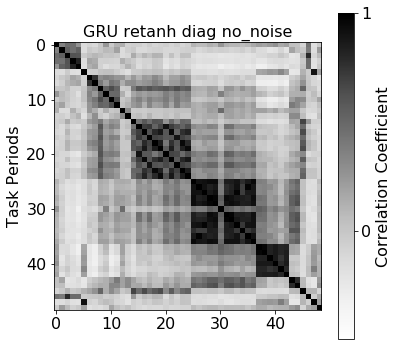

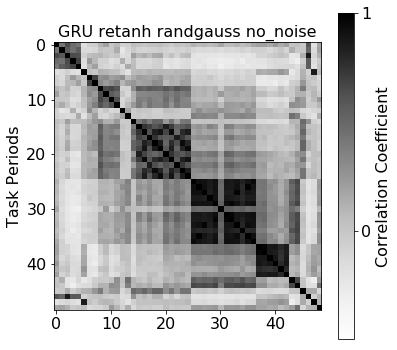

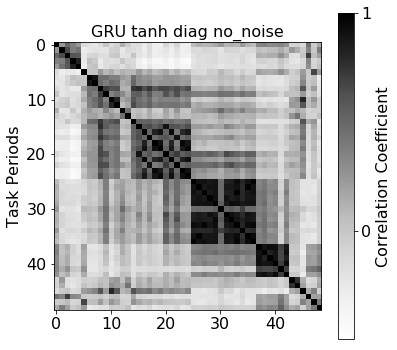

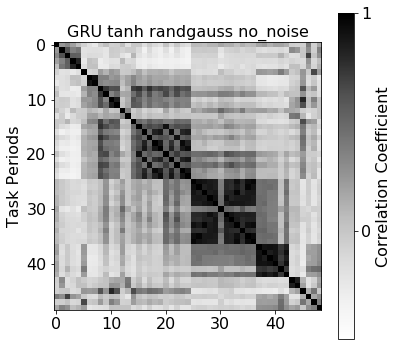

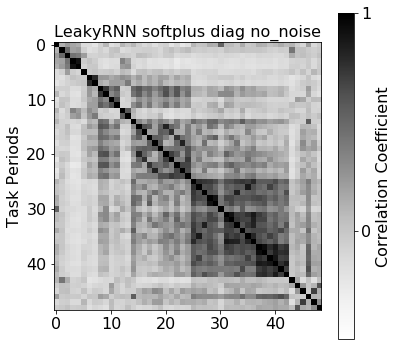

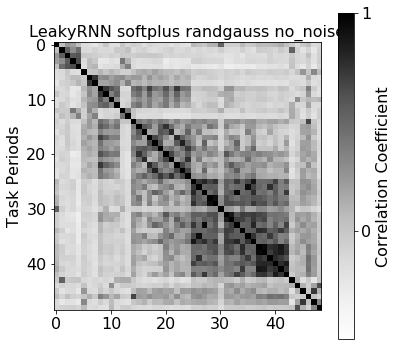

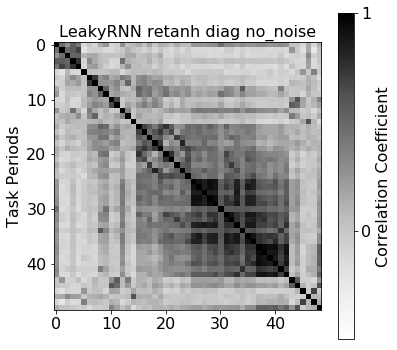

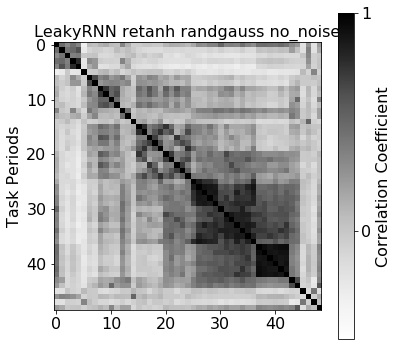

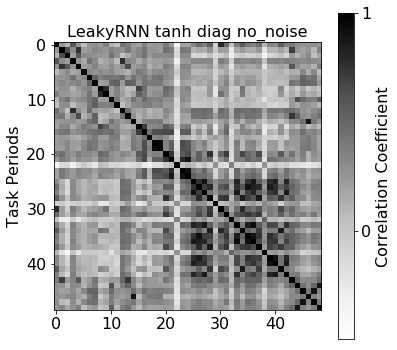

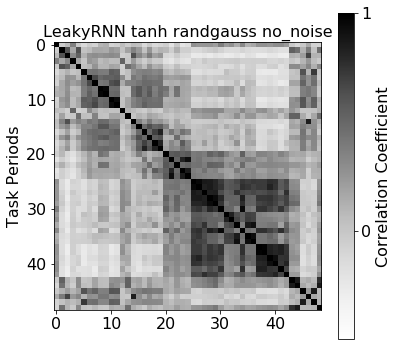

In [58]:
##################################################################
#Find right model dir
##################################################################
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
method = 'ward'
max_d = 3.5
seed_set = [str(0),]#[str(0),str(1)],str(1),str(2)

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_trains_str = '_'.join(rule_trains)

n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -0
l2h = -0
l1w = 0
l1h = 0
lr = -7
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder_all = 'data/rnn/multitask/stepnet/'

#visualize atlas for master network


# set of networks to compare
rnn_type_set = ['GRU','LeakyRNN']
activation_set = ['softplus','retanh','tanh']
w_init_set = ['diag','randgauss']
data_folder_set = ['no_noise',]# 'lr','untrained',

for rnn_type_i in range(len(rnn_type_set)):
    for activation_i in range(len(activation_set)):
        for w_init_i in range(len(w_init_set)):
            for data_folder in data_folder_set:
                fig = plt.figure(figsize=(6,6))
            
                c = color_set[data_folder]
                rnn_type = rnn_type_set[rnn_type_i]
                activation = activation_set[activation_i]
                w_init = w_init_set[w_init_i]

                for seed in seed_set:

                    m = os.path.join(p,data_folder_all,data_folder,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',
                                     net_name,seed)
                    #load atlas data
                    save_dir = os.path.join(m,lesion_folder)
                    cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
                    D = cluster_var['D'].T
                    feature_names_original = [cluster_var['tick_names'][s] for s in range(len(cluster_var['tick_names']))]

                    feat_order = [feature_names_original.index(s) for i,s in enumerate(feature_names_master)]
                    X = D[:,feat_order]

                    corr_mat = np.corrcoef(X.T)

                    if seed==seed_set[0]:
                        corr_mat_stack = corr_mat[:,np.newaxis]
                    else:
                        corr_mat_stack = np.concatenate((corr_mat_stack,corr_mat[:,np.newaxis]),axis=1)

                corr_mat_ave = np.mean(corr_mat_stack,axis = 1)

                plt.imshow(corr_mat_ave,cmap= 'Greys',clim = (-.5,1))
                label = ' '.join([rnn_type,activation,w_init])
                plt.title(label+ ' ' +data_folder, fontsize = 16)
                cbar = plt.colorbar(ticks=[-1, 0, 1])
                cbar.set_label('Correlation Coefficient')

                plt.ylabel('Task Periods')
                corr_mat_stack = []

                plt.show()